# Annual Sea Level Anomalies
```{glue:figure} SL_MMA_annual_station
:scale: 25%
:align: right
```

In this notebook, we'll be taking a look at sea level anomalies (SLA), which can be thought of as signals that differ from the climatology (of a station or region). For these products we'll focus on yearly anomalies. For a nice overview and animation of daily mean SLAs in the Hawaii and eastern Pacific region, see [Pacific Sea Level Monitoring](https://uhslc.soest.hawaii.edu/pacific-sea-level-monitoring/).


## Setup

As with previous sections, we first need to import the necessary libraries, establish our input/output directories, and set up some basic plotting rules. 

In [1]:
# import necessary libraries
import numpy as np
import xarray as xr
import datetime as dt
from pathlib import Path
import pandas as pd
import os
import os.path as op
import sys

# data retrieval libraries
import requests
from urllib.request import urlretrieve #used for downloading files
import json
import copernicusmarine

# data processing libraries
from scipy import stats
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

from myst_nb import glue #used for figure numbering when exporting to LaTeX

sys.path.append("../../../functions")
from data_downloaders import download_oni_index, download_uhslc_data


In [2]:
data_dir = Path('../../../data')
path_figs = "../../../matrix_cc/figures"
data_dir = Path(data_dir,'sea_level')
output_dir = data_dir 

# Create the output directory if it does not exist
output_dir.mkdir(exist_ok=True)
data_dir.mkdir(exist_ok=True)

 ##  Retrieve the Tide Station(s) Data Set(s)

Next, we'll access data from the UHSLC. The Malakala tide gauge has the UHSLC ID: 7. We will import the netcdf file into our current data directory, and take a peek at the dataset. We will also import the datums for this location. 

In [3]:
uhslc_id = 7
# download the hourly data
rsl = download_uhslc_data(data_dir, uhslc_id, frequency='daily')

 make it relative to MSL (to look at anomalies)

In [4]:
def get_MHHW_uhslc_datums(id, datumname): 
    
    url = 'https://uhslc.soest.hawaii.edu/stations/TIDES_DATUMS/fd/LST/fd'+f'{int(id):03}'+'/datumTable_'+f'{int(id):03}'+'_mm_GMT.csv'
    datumtable = pd.read_csv(url)
    datum = datumtable[datumtable['Name'] == datumname]['Value'].values[0]
    # ensure datum is a float
    datum = float(datum)
    return datum, datumtable

In [5]:
rsl

<xarray.Dataset> Size: 248kB
Dimensions:               (record_id: 1, time: 20620)
Coordinates:
  * time                  (time) datetime64[ns] 165kB 1969-05-19T12:00:00 ......
  * record_id             (record_id) int64 8B 7
Data variables:
    sea_level             (record_id, time) float32 82kB ...
    lat                   (record_id) float32 4B ...
    lon                   (record_id) float32 4B ...
    station_name          (record_id) <U7 28B 'Malakal'
    station_country       (record_id) <U5 20B 'Palau'
    station_country_code  (record_id) float32 4B ...
    uhslc_id              (record_id) int16 2B ...
    gloss_id              (record_id) float32 4B ...
    ssc_id                (record_id) |S4 4B ...
    last_rq_date          (record_id) datetime64[ns] 8B ...
Attributes:
    title:                  UHSLC Fast Delivery Tide Gauge Data (daily)
    ncei_template_version:  NCEI_NetCDF_TimeSeries_Orthogonal_Template_v2.0
    featureType:            timeSeries
    Conventions:            CF-1.6, ACDD-1.3
    date_created:           2025-12-22T14:27:15Z
    publisher_name:         University of Hawaii Sea Level Center (UHSLC)
    publisher_email:        philiprt@hawaii.edu, markm@soest.hawaii.edu
    publisher_url:          http://uhslc.soest.hawaii.edu
    summary:                The UHSLC assembles and distributes the Fast Deli...
    processing_level:       Fast Delivery (FD) data undergo a level 1 quality...
    acknowledgment:         The UHSLC Fast Delivery database is supported by ...

In [6]:
# extract the given datum from the dataframe
datumname = 'MSL'

datum, datumtable = get_MHHW_uhslc_datums(uhslc_id, datumname)

rsl['datum'] = datum # already in mm
rsl['sea_level_msl'] = rsl['sea_level'] - rsl['datum']

# assign units to datum and sea level
rsl['datum'].attrs['units'] = 'mm'
rsl['sea_level_msl'].attrs['units'] = 'mm'


# calculate altimetry epoch mean for later use
epoch_daily_mean = rsl['sea_level_msl'].sel(time=slice('1993-01-01', '2012-12-31')).mean() 

#### 2. Now we'll remove the trend (over the entire record) from the station.

In [7]:
def process_trend_with_nan(data,var):
    # Remove NaN values
    data = data[var].dropna(dim='time')

    # Convert time to numerical values (ordinal format)
    time = data['time']
    time_num = time.astype('datetime64[D]').astype(float)  # Convert to days since epoch
    # Fit a trendline (degree 1 polynomial)
    data = data[0].values
    coefficients = np.polyfit(time_num, data, 1)  # Linear fit
    trendline = np.poly1d(coefficients)  # Create trendline function

    return coefficients, trendline, coefficients[0] * 365.25  # Return the slope as mm/year

In [8]:
coefficients, trend_fxn, trend_rate = process_trend_with_nan(rsl,'sea_level_msl')

sea_level_trend = trend_fxn(rsl['time'].astype('datetime64[D]').astype(float))
rsl['sea_level_anomaly_detrended'] = rsl['sea_level_msl'] - sea_level_trend


/var/folders/88/z9xxhn052qddjc_ppp2j_8gr0000gn/T/ipykernel_77868/4268275979.py:7: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  time_num = time.astype('datetime64[D]').astype(float)  # Convert to days since epoch
/var/folders/88/z9xxhn052qddjc_ppp2j_8gr0000gn/T/ipykernel_77868/776025258.py:3: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.dat

#### 3. Resample to monthly time series of anomalies.

In [9]:
# resample to monthly time series 
rsl_monthly = rsl.resample(time='1MS',label='left').mean()

# get climatology (annual cycle) by grouping by month
rsl_climatology = rsl_monthly.groupby('time.month').mean('time')

# get anomalies by subtracting climatology from monthly data
rsl_anomalies = rsl_monthly.groupby('time.month') - rsl_climatology

rsl_anomalies

<xarray.Dataset> Size: 46kB
Dimensions:                      (record_id: 1, time: 678)
Coordinates:
  * record_id                    (record_id) int64 8B 7
  * time                         (time) datetime64[ns] 5kB 1969-05-01 ... 202...
    month                        (time) int64 5kB 5 6 7 8 9 10 ... 5 6 7 8 9 10
Data variables:
    sea_level                    (time, record_id) float32 3kB -74.49 ... 123.2
    lat                          (time, record_id) float32 3kB -4.768e-07 ......
    lon                          (time, record_id) float32 3kB 0.0 0.0 ... 0.0
    station_country_code         (time, record_id) float32 3kB 0.0 0.0 ... 0.0
    uhslc_id                     (time, record_id) float64 5kB 0.0 0.0 ... 0.0
    gloss_id                     (time, record_id) float32 3kB 0.0 0.0 ... 0.0
    datum                        (time) float64 5kB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    sea_level_msl                (time, record_id) float64 5kB -74.49 ... 123.2
    sea_level_anomaly_detrended  (time, record_id) float64 5kB -11.95 ... 61.64

#### 4. Now sort the subset on "storm year" instead of calendar year for yearly means.

In [10]:
# change the index to be on storm_time instead of time
rsl_years = rsl.copy()
rsl_years['storm_time'] = rsl_years['time']
rsl_years['storm_time'] = xr.DataArray(
    pd.to_datetime(rsl_years['storm_time'].values).to_series().apply(
        lambda x: x if x.month >= 5 else x - pd.DateOffset(years=1)
    ),
    dims=rsl_years['storm_time'].dims,
    coords=rsl_years['storm_time'].coords
)
rsl_years = rsl_years.set_index(time='storm_time')

# # # rename the time dimension to storm_time
rsl_years = rsl_years.rename({'time':'storm_time'})
rsl_years

<xarray.Dataset> Size: 577kB
Dimensions:                      (record_id: 1, storm_time: 20620)
Coordinates:
  * storm_time                   (storm_time) datetime64[ns] 165kB 1969-05-19...
  * record_id                    (record_id) int64 8B 7
Data variables: (12/13)
    sea_level                    (record_id, storm_time) float32 82kB ...
    lat                          (record_id) float32 4B 7.33
    lon                          (record_id) float32 4B 134.5
    station_name                 (record_id) <U7 28B 'Malakal'
    station_country              (record_id) <U5 20B 'Palau'
    station_country_code         (record_id) float32 4B 585.0
    ...                           ...
    gloss_id                     (record_id) float32 4B 120.0
    ssc_id                       (record_id) |S4 4B b'mala'
    last_rq_date                 (record_id) datetime64[ns] 8B 2018-12-31T12:...
    datum                        float64 8B 1.532e+03
    sea_level_msl                (record_id, storm_time) float64 165kB -56.0 ...
    sea_level_anomaly_detrended  (record_id, storm_time) float64 165kB -11.66...
Attributes:
    title:                  UHSLC Fast Delivery Tide Gauge Data (daily)
    ncei_template_version:  NCEI_NetCDF_TimeSeries_Orthogonal_Template_v2.0
    featureType:            timeSeries
    Conventions:            CF-1.6, ACDD-1.3
    date_created:           2025-12-22T14:27:15Z
    publisher_name:         University of Hawaii Sea Level Center (UHSLC)
    publisher_email:        philiprt@hawaii.edu, markm@soest.hawaii.edu
    publisher_url:          http://uhslc.soest.hawaii.edu
    summary:                The UHSLC assembles and distributes the Fast Deli...
    processing_level:       Fast Delivery (FD) data undergo a level 1 quality...
    acknowledgment:         The UHSLC Fast Delivery database is supported by ...

In [11]:
# reorder to that storm_time is monotonicly increasing
rsl_subset = rsl_years.sortby('storm_time')

# Group by storm_year and record_id
rsl_yearly_mean = rsl_years.groupby('storm_time.year').mean('storm_time')

# give year dimension a name
rsl_yearly_mean = rsl_yearly_mean.rename({'year':'storm_year'})

rsl_yearly_mean

<xarray.Dataset> Size: 7kB
Dimensions:                      (storm_year: 57, record_id: 1)
Coordinates:
  * record_id                    (record_id) int64 8B 7
  * storm_year                   (storm_year) int64 456B 1969 1970 ... 2024 2025
Data variables: (12/13)
    sea_level                    (storm_year, record_id) float32 228B 1.454e+...
    lat                          (storm_year, record_id) float32 228B 7.33 .....
    lon                          (storm_year, record_id) float32 228B 134.5 ....
    station_name                 (storm_year, record_id) <U7 2kB 'Malakal' .....
    station_country              (storm_year, record_id) <U5 1kB 'Palau' ... ...
    station_country_code         (storm_year, record_id) float32 228B 585.0 ....
    ...                           ...
    gloss_id                     (storm_year, record_id) float32 228B 120.0 ....
    ssc_id                       (storm_year, record_id) |S4 228B b'mala' ......
    last_rq_date                 (storm_year, record_id) datetime64[ns] 456B ...
    datum                        (storm_year) float64 456B 1.532e+03 ... 1.53...
    sea_level_msl                (storm_year, record_id) float64 456B -77.87 ...
    sea_level_anomaly_detrended  (storm_year, record_id) float64 456B -34.66 ...
Attributes:
    title:                  UHSLC Fast Delivery Tide Gauge Data (daily)
    ncei_template_version:  NCEI_NetCDF_TimeSeries_Orthogonal_Template_v2.0
    featureType:            timeSeries
    Conventions:            CF-1.6, ACDD-1.3
    date_created:           2025-12-22T14:27:15Z
    publisher_name:         University of Hawaii Sea Level Center (UHSLC)
    publisher_email:        philiprt@hawaii.edu, markm@soest.hawaii.edu
    publisher_url:          http://uhslc.soest.hawaii.edu
    summary:                The UHSLC assembles and distributes the Fast Deli...
    processing_level:       Fast Delivery (FD) data undergo a level 1 quality...
    acknowledgment:         The UHSLC Fast Delivery database is supported by ...

## Absolute Value: satellite (trend removed)

In [12]:
def get_CMEMS_data(data_dir):
        
    maxlat = 15
    minlat = 0
    minlon = 125
    maxlon = 140
    
    start_date_str = "1993-01-01T00:00:00"
    end_date_str = "2025-04-30T23:59:59"
    data_dir = data_dir
    
    """
    Retrieves Copernicus Marine data for a specified region and time period.
    
    Args:
        minlon (float): Minimum longitude of the region.
        maxlon (float): Maximum longitude of the region.
        minlat (float): Minimum latitude of the region.
        maxlat (float): Maximum latitude of the region.
        start_date_str (str): Start date of the data in ISO 8601 format.
        end_date_str (str): End date of the data in ISO 8601 format.
        data_dir (str): Directory to save the retrieved data.
    
    Returns:
        str: The filename of the retrieved data.
    """
    copernicusmarine.subset(
        dataset_id="cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.125deg_P1D",
        variables=["adt", "sla"],
        minimum_longitude=minlon,
        maximum_longitude=maxlon,
        minimum_latitude=minlat,
        maximum_latitude=maxlat,
        start_datetime=start_date_str,
        end_datetime=end_date_str,
        output_directory=data_dir,
        output_filename="cmems_L4_SSH_0.125deg_" + start_date_str[0:4] + "_" + end_date_str[0:4] + ".nc"
    )

In [13]:
fname_cmems = 'cmems_L4_SSH_0.125deg_1993_2025.nc'

# check if the file exists, if not, download it
if not os.path.exists(data_dir / fname_cmems):
    print('You will need to download the CMEMS data in a separate script')
    get_CMEMS_data(data_dir) #<<--- COMMENT OUT TO AVOID ACCIDENTAL DATA DOWNLOADS.
else:
    print('CMEMS data already downloaded, good to go!')

# open the CMEMS data
cmems = xr.open_dataset(data_dir / fname_cmems)

# slice the data to time 1993-01-01 to 2022-12-31
start_date = '1993-01-01'
end_date = '2022-12-31'
cmems = cmems.sel(time=slice(start_date, end_date))
epoch_daily_mean_cmems = cmems['sla'].sel(time=slice(start_date, '2012-12-31')).mean()

# put cmems data into the same MSL (NTDE) reference frame
cmems['sla'] = cmems['sla'] - epoch_daily_mean_cmems - epoch_daily_mean


CMEMS data already downloaded, good to go!


### Plot an area-wide map, with stations
First we'll need to make sure that our data is detrended properly in order to look at yearly anomalies.

In [14]:
def process_trend_with_nan(sea_level_anomaly):
    # Flatten the data and get a time index
    # first ensure time is the first dimension regardless of other dimensions
    sea_level_anomaly = sea_level_anomaly.transpose('time', ...)
    sla_flat = sea_level_anomaly.values.reshape(sea_level_anomaly.shape[0], -1)
    time_index = pd.to_datetime(sea_level_anomaly.time.values).to_julian_date()

    detrended_flat = np.full_like(sla_flat, fill_value=np.nan)
    detrended_flat_err = np.full_like(sla_flat, fill_value=np.nan)
    trend_rates = np.full(sla_flat.shape[1], np.nan)
    trend_errors = np.full(sla_flat.shape[1], np.nan)
    p_values = np.full(sla_flat.shape[1], np.nan)



    # Loop over each grid point
    for i in range(sla_flat.shape[1]):
        # Get the time series for this grid point
        y = sla_flat[:,i]
        mask = ~np.isnan(y)

        if np.any(mask):
            time_masked = time_index[mask]
            y_masked = y[mask]

            slope, intercept, _, p_value, std_error = stats.linregress(time_masked, y_masked)
            trend = slope * time_index + intercept

            detrended_flat[:,i] = y - trend
            trend_rates[i] = slope
            trend_errors[i] = std_error
            p_values[i] = p_value

    detrended = detrended_flat.reshape(sea_level_anomaly.shape)
    trend_errors_reshaped = trend_errors.reshape(sea_level_anomaly.shape[1:])

    # Calculate trend magnitude
    sea_level_trend = sea_level_anomaly - detrended
    trend_mag = sea_level_trend[-1] - sea_level_trend[0]

    times = pd.to_datetime(sea_level_anomaly['time'].values)
    time_mag = (times[-1] - times[0]).days/365.25 # in years

    trend_rate = trend_mag / time_mag
    trend_err = trend_errors_reshaped / time_mag

    return trend_mag, sea_level_trend, trend_rate, np.nanmean(p_value) , np.nanmean(trend_err)

In [15]:
# concentrating on decadal trends
# let's look at 1993-2003 and 2003-2013

trend_mag_cmems, trend_line_cmems, trend_rate_cmems, p_value_cmems, trend_err_cmems = process_trend_with_nan(cmems['sla'])

In [16]:
def plot_map(vmin, vmax, xlims, ylims):
    """
    Plot a map of the magnitude of sea level change.

    Parameters:
    vmin (float): Minimum value for the color scale.
    vmax (float): Maximum value for the color scale.
    xlims (tuple): Tuple of min and max values for the x-axis limits.
    ylims (tuple): Tuple of min and max values for the y-axis limits.

    Returns:
    fig (matplotlib.figure.Figure): The matplotlib figure object.
    ax (matplotlib.axes._subplots.AxesSubplot): The matplotlib axes object.
    crs (cartopy.crs.Projection): The cartopy projection object.
    cmap (matplotlib.colors.Colormap): The colormap used for the plot.
    """
    crs = ccrs.PlateCarree()
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection': crs})
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)

    palette = sns.color_palette("mako_r", as_cmap=True)
    cmap = palette

    ax.coastlines()
    ax.add_feature(cfeature.LAND, color='lightgrey')

    return fig, ax, crs, cmap

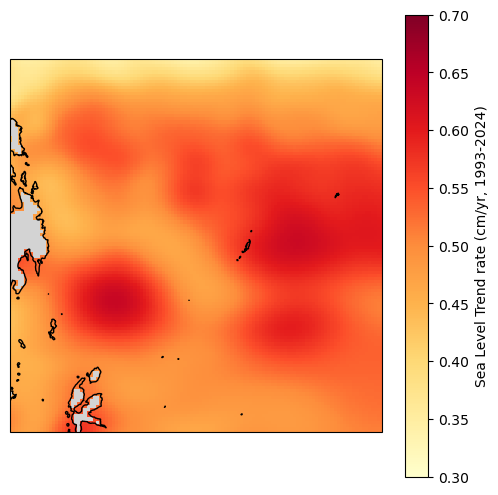

In [17]:
import warnings # import warnings to suppress warnings in cartopy
# Ignore the specific shapely warning for this cell
warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in create_collection")


# define vmin and vmax variables
vmin = 0.3
vmax = 0.7
# Use float values for map extent to avoid dtype issues and ensure gridlines appear
xlims = [float(cmems.longitude.min()), float(cmems.longitude.max())]
ylims = [float(cmems.latitude.min()), float(cmems.latitude.max())]
trend_rate_cm = trend_rate_cmems * 100  # convert to cm/yr

# make ax,fig
crs = ccrs.PlateCarree()

fig, ax, crs, cmap = plot_map(vmin,vmax,xlims,ylims)
cmap = 'YlOrRd'
trend_rate_cm.plot(ax=ax, transform=crs,
                         vmin=vmin, vmax=vmax, cmap=cmap, add_colorbar=True, 
                         cbar_kwargs={'label': 'Sea Level Trend rate (cm/yr, 1993-2024)'}
)


# save the figure
# plt.savefig(output_dir / '1.2_cmems_trend_rate_1993_2024.png', dpi=300, bbox_inches='tight')


### Area-weighted average trend 

As an example, we can use the entire grid for this. That said, in reality, you'd want to pick boundaries that make more sense. You could, for example, use the EEZ.

In [18]:
startYear = '1993'
endYear = '2024'

# First, compute the area-weighted mean time series
weights = np.cos(np.deg2rad(cmems.latitude))
weights.name = "weights"
sla_weighted = cmems['sla'].sel(time=slice(startYear,endYear)).weighted(weights)
sla_regional_mean = sla_weighted.mean(dim=('latitude', 'longitude'))
trend_mag, trend_line, trend_rate, p_value, trend_err = process_trend_with_nan(sla_regional_mean)

trend_rate_computed = trend_rate.compute()
print(f'The trend rate for {startYear}-{endYear} in the entire grid is {trend_rate_computed*100:.2f} cm/yr')


The trend rate for 1993-2024 in the entire grid is 0.51 cm/yr


In [19]:
# concentrating on decadal trends
# let's look at 1993-2003 and 2003-2013
cmems1993_2003 = cmems.sel(time=slice('1993','2003'))

# get the overall trend (full time series)
trend_mag, sea_level_trend, trend_rate,p_value, trend_err = process_trend_with_nan(cmems['sla'])

sla_weighted = cmems['sla'].weighted(weights)
sla_regional_mean = sla_weighted.mean(dim=('latitude', 'longitude'))
trend_mag_area_weighted, sea_level_trend_area_weighted, trend_rate_area_weighted, p_value_area_weighted, trend_err_area_weighted = process_trend_with_nan(sla_regional_mean)


#remove the trend from the data
sla_detrended = cmems1993_2003['sla'] - sea_level_trend.sel(time=slice('1993','2003'))
sla_detrended_area_weighted = cmems1993_2003['sla'] - sea_level_trend_area_weighted

Let's check this for a random station in our list.

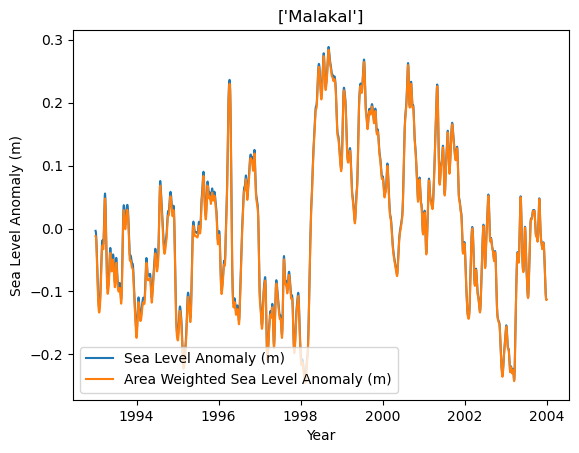

In [20]:

lat = rsl.lat
lon = rsl.lon
sla_detrended.sel(latitude=lat, longitude=lon, method='nearest').plot(label='Sea Level Anomaly (m)')
sla_detrended_area_weighted.sel(latitude=lat, longitude=lon, method='nearest').plot(label='Area Weighted Sea Level Anomaly (m)')

# change the title to station name
plt.title(rsl['station_name'].values)
#add axis labels
plt.xlabel('Year')
plt.ylabel('Sea Level Anomaly (m)')

plt.legend()

There are slight differences between removing the grid-level trend versus the area-weighted trend in this plot. Nothing too major here.

### Create a map
Concentrating on decadal trends.

In [21]:
# concentrating on decadal trends
# let's look at 1993-2003 and 2003-2013

yr_start = [1993,2003,2013,2003]
yr_stop = [2003,2013,2023,2023]

#do storm year instead of calendar year

yr_start_str = [str(int(yr))+'-05-01' for yr in yr_start]
yr_stop_str = [str(int(yr+1))+'-04-30' for yr in yr_stop]

trend_mag, sea_level_trend, trend_rate,p_value, trend_err = process_trend_with_nan(cmems['sla'].sel(time=slice(yr_start_str[0],yr_stop_str[-1])))

#remove the trend from the data
sla_detrended = cmems['sla'] - sea_level_trend 

In [22]:
rsl_anomalies

<xarray.Dataset> Size: 46kB
Dimensions:                      (record_id: 1, time: 678)
Coordinates:
  * record_id                    (record_id) int64 8B 7
  * time                         (time) datetime64[ns] 5kB 1969-05-01 ... 202...
    month                        (time) int64 5kB 5 6 7 8 9 10 ... 5 6 7 8 9 10
Data variables:
    sea_level                    (time, record_id) float32 3kB -74.49 ... 123.2
    lat                          (time, record_id) float32 3kB -4.768e-07 ......
    lon                          (time, record_id) float32 3kB 0.0 0.0 ... 0.0
    station_country_code         (time, record_id) float32 3kB 0.0 0.0 ... 0.0
    uhslc_id                     (time, record_id) float64 5kB 0.0 0.0 ... 0.0
    gloss_id                     (time, record_id) float32 3kB 0.0 0.0 ... 0.0
    datum                        (time) float64 5kB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    sea_level_msl                (time, record_id) float64 5kB -74.49 ... 123.2
    sea_level_anomaly_detrended  (time, record_id) float64 5kB -11.95 ... 61.64

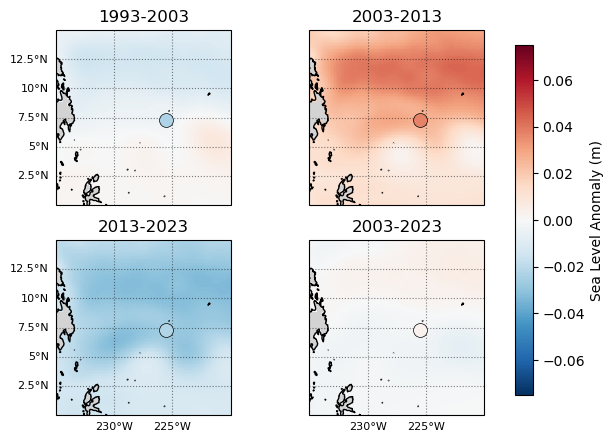

In [23]:
# make 4 subplots for each year range
from matplotlib.ticker import FuncFormatter

def pacific_all_west_formatter(x, pos=None):
    # Convert to [0, 360)
    x = (x + 360) % 360
    deg_west = (180 - x) % 360
    if deg_west == 0:
        return "180°W"
    else:
        return f"{abs(deg_west):.0f}°W"

crs_main = ccrs.PlateCarree(central_longitude=180)
crs_sub = ccrs.PlateCarree()
fig, ax = plt.subplots(2,2,figsize=(6, 5), subplot_kw={'projection': crs_main})

# Variable to hold the colorbar handle
cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])  # Adjust these values to fit your layout
fig.subplots_adjust(right=0.9)  # Make space for the colorbar
 
vmin = -0.075
vmax = 0.075
# Loop through each period
for i, ax in enumerate(ax.flat):
    # Select the data for the current period and calculate the mean over time
    sla_mean = sla_detrended.sel(time=slice(yr_start_str[i],yr_stop_str[i])).mean(dim='time',skipna=True)
    # sla_mean = sla_mean - sea_level_trend.sel(time=slice(str(yr_start[i]), str(yr_stop[i]))).mean(dim='time')

    #subtract the
    
    # Plot the mean sea level anomaly
    c = sla_mean.plot(ax=ax, add_colorbar=False, transform=crs_sub, cmap='RdBu_r')
    
    # Set the title to the current period
    ax.set_title(f'{yr_start[i]}-{yr_stop[i]}')

    # Add coastlines and land  
    palette = sns.color_palette("RdBu_r", as_cmap=True)
    cmap = palette

    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAND, color='lightgrey')
    
    # Optionally, adjust color limits for consistency across plots
    c.set_clim(vmin,vmax)

    ax.scatter(rsl['lon'], rsl['lat'], transform=crs_sub, s=50,
              c='white', linewidth=0.5, edgecolor='black',zorder=10)

    ax.scatter(rsl['lon'], rsl['lat'], transform=crs_sub, s=100,
           c=rsl_anomalies.sel(time=slice(yr_start_str[i],yr_stop_str[i])).sea_level_anomaly_detrended.mean(dim="time")/1000, vmin=vmin, vmax=vmax, cmap=cmap,
           linewidth=0.5, edgecolor='black',zorder=10)
    
    #add grid
    gl = ax.gridlines(crs=crs_main, draw_labels=False, linestyle=':', color='black',
                      alpha=0.5,xlocs=ax.get_xticks(),ylocs=ax.get_yticks())
    gl.xformatter = FuncFormatter(pacific_all_west_formatter)
    
    if i>1:
        gl.bottom_labels = True

    if i==0:
        gl.left_labels = True

    if i==2:
        gl.left_labels = True

    #make all labels tiny
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}

# Add the colorbar
cbar = fig.colorbar(c, cax=cbar_ax)
cbar.set_label('Sea Level Anomaly (m)')

glue("SL_YMA_decadal",fig,display=False)

plt.savefig(output_dir / '1.2_2_SL_anomaly_annual_map_decadal.png', dpi=300, bbox_inches='tight')


```{glue:figure} SL_YMA_decadal
:name: "SL_YMA_decadal"

Decadal (or bidecadal) mean anomalies of the Hawaiian Islands region, background trend (Storm Years 1993-2023) removed. Note that the sea level is plotted in units of m. The mean anomaly is near zero when using the full timeseries and grid-level trends (i.e. no area-weighted averaging). Mean monthly anomalies at the stations are plotted as well, showing similar-ish patterns.
```

## Time Series Plots
Now we'll look at monthly and yearly anomalies at the tide stations through time. We'll also plot ENSO signals on the same plot, to get a visual feel for any ENSO-driven anomalous effects on sea level.

In [24]:
def plot_TG_rsl_anomaly_annual(rid, fig, ax, rsl_yearly_mean, rsl_subset, rsl_anomalies,oni, oniPlot=False):

    ax.set_xlim(1993,2024)
    ax.set_ylim(-0.5, 0.5)
    ax.grid(alpha=0.2, color='lightgray')

    if oniPlot:
        ymin, ymax = ax.get_ylim()
        # Shading El Niño events
        ax.fill_between(oni.index, ymin,ymax, 
                        where=oni['El Nino'] == 1, color='red', alpha=0.1, label='El Niño')
        # Shading La Niña events
        ax.fill_between(oni.index,  ymin,ymax,
                        where=oni['La Nina'] == 1, color='blue', alpha=0.1, label='La Niña')
    
    # get min and max for each year
    rsl_yearly_min = rsl_subset.groupby('storm_time.year').min('storm_time').isel(record_id=rid)
    rsl_yearly_max = rsl_subset.groupby('storm_time.year').max('storm_time').isel(record_id=rid)

    rsl_yearly_min = rsl_yearly_min['sea_level_anomaly_detrended']/1000
    rsl_yearly_max = rsl_yearly_max['sea_level_anomaly_detrended']/1000

    #make a fill from max to min for each month
    ax.fill_between(rsl_yearly_mean.storm_year+0.5, 
                     rsl_yearly_min, rsl_yearly_max, 
                     alpha=0.2, label='Range (Annual SLA Min-Max)')

    ax.plot(rsl_yearly_mean.storm_year+0.5, 
            0.001*rsl_yearly_mean['sea_level_anomaly_detrended'].isel(record_id=rid), 
            label='Annual Mean Sea Level Anomaly (m)',alpha=1,linewidth=2)

    # convert rsl_monthly['time'] to float
    storm_time_float = rsl_monthly['time.year'] + (rsl_monthly['time.month']-5)/12 #subtract 5 months to go with 'storm year' convention (May-April)
    ax.plot(storm_time_float, 
            0.001*rsl_monthly['sea_level_anomaly_detrended'].isel(record_id=rid), 
            label='Monthly Mean Sea Level Anomaly (m)',alpha=1, color='gray',linewidth=0.75)
    ax.set_ylabel(''), ax.set_xlabel('')

    # add rsl_yearly_mean['station_name'].isel(record_id=rid).values to upper center of plot
    nameID = str(rsl_subset['station_name'].isel(record_id=rid).values) + ' (' + str(rsl_subset['record_id'].isel(record_id=rid).values).zfill(3) + ')'
    ax.text(0.5, 0.9, nameID, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

First, we'll plot one gauge

In [25]:
def detect_enso_events(oni_df):
    """
    Detects El Niño and La Niña events within a storm year based on the ONI index.
    An El Niño event is defined as having 5 consecutive months with ONI > 0.5.
    A La Niña event is defined as having 5 consecutive months with ONI < -0.5.

    Parameters:
    oni_df (pd.DataFrame): DataFrame containing the ONI index with a datetime index.

    Returns:
    pd.DataFrame: DataFrame with ENSO mode classification.
    """
    oni_df['ONI Mode'] = 'Neutral'
    oni_df['year_storm'] = oni_df.index.year
    oni_df.loc[oni_df.index.month < 5, 'year_storm'] -= 1
    
    # El Nino: mark a month as El Nino if it's part of any 5-month period where all months exceed 0.5
    el_nino_rolling = (oni_df['ONI'] > 0.5).rolling(window=5, min_periods=5).sum() == 5
    # Expand to mark all months within the 5-month window
    oni_df['El Nino'] = False
    for i in range(len(oni_df)):
        if el_nino_rolling.iloc[i]:
            # Mark current month and previous 4 months
            start_idx = max(0, i - 4)
            oni_df.iloc[start_idx:i+1, oni_df.columns.get_loc('El Nino')] = True
    
    # La Nina: mark a month as La Nina if it's part of any 5-month period where all months are below -0.5
    la_nina_rolling = (oni_df['ONI'] < -0.5).rolling(window=5, min_periods=5).sum() == 5
    # Expand to mark all months within the 5-month window
    oni_df['La Nina'] = False
    for i in range(len(oni_df)):
        if la_nina_rolling.iloc[i]:
            # Mark current month and previous 4 months
            start_idx = max(0, i - 4)
            oni_df.iloc[start_idx:i+1, oni_df.columns.get_loc('La Nina')] = True

    # Set ONI Mode based on results
    oni_df.loc[oni_df['La Nina'] == True, 'ONI Mode'] = 'La Nina'
    oni_df.loc[oni_df['El Nino'] == True, 'ONI Mode'] = 'El Nino'
    
    return oni_df

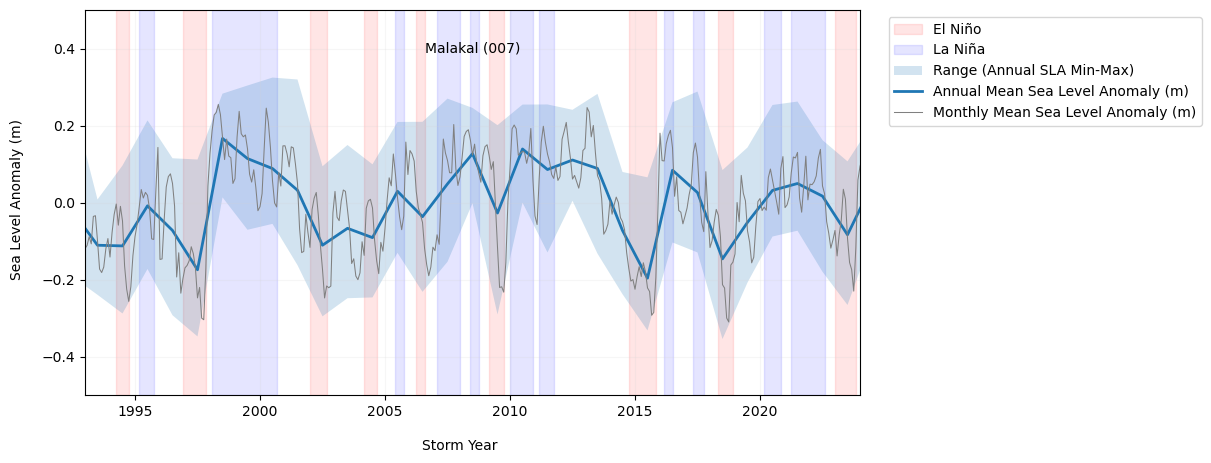

In [26]:
fig,ax = plt.subplots(figsize=(10,5))
# add ENSO to the plots
# import oni.csv
p_data = 'https://psl.noaa.gov/data/correlation/oni.data'
oni = download_oni_index(p_data)

#adjust the index to be float value of fractional year (storm year)
enso_events = detect_enso_events(oni)
enso_events.index = pd.to_datetime(enso_events.index )
enso_events.index = enso_events.index.year + (enso_events.index.month - 1)/12 -5/12

sid = 0
plot_TG_rsl_anomaly_annual(sid, fig, ax,  rsl_yearly_mean, rsl_years, rsl_anomalies,enso_events,oniPlot=True)
ax.legend(loc='upper right', ncol=1, bbox_to_anchor=(1.45, 1.0))

# # Save the plot to a file
# filename = 'sea_level_MMA_annual_' + str(rsl_yearly_mean['station_name'].isel(record_id=sid).values) + '.png'
# plt.savefig(output_dir / filename, dpi=300, bbox_inches='tight')

fig.text(0.05, 0.5, 'Sea Level Anomaly (m)', va='center', rotation='vertical')
fig.text(0.5, 0, 'Storm Year', ha='center')

glue('SL_MMA_annual_station',fig,display=False)
station = str(rsl['station_name'].isel(record_id=sid).values)

glue('station',station,display=False)

```{glue:figure} SL_MMA_annual_station
:name: "SL_MMA_annual_station"

Yearly mean anomalies at the {glue:text}`station` tide gauge with background trend removed (blue). The shaded region about the annual mean denotes the annual means of the daily min and max sea level. Note that the sea level is plotted in units of m. The monthly mean anomaly (gray) is calculated with respect to the annual cycle. El Niño and La Niño time periods are derived from the Oceanic Niño Index (ONI), available at https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php  
```

In [27]:
p_data = 'https://psl.noaa.gov/data/correlation/oni.data'
oni = download_oni_index(p_data)
enso_events = detect_enso_events(oni)
enso_events

,ONI,ONI Mode,year_storm,El Nino,La Nina
1951-01-01,-0.82,Neutral,1950,False,False
1951-02-01,-0.54,Neutral,1950,False,False
1951-03-01,-0.17,Neutral,1950,False,False
1951-04-01,0.18,Neutral,1950,False,False
1951-05-01,0.36,Neutral,1951,False,False
...,...,...,...,...,...
2025-08-01,-0.32,Neutral,2025,False,False
2025-09-01,-0.45,Neutral,2025,False,False
2025-10-01,NaN,Neutral,2025,False,False
2025-11-01,NaN,Neutral,2025,False,False


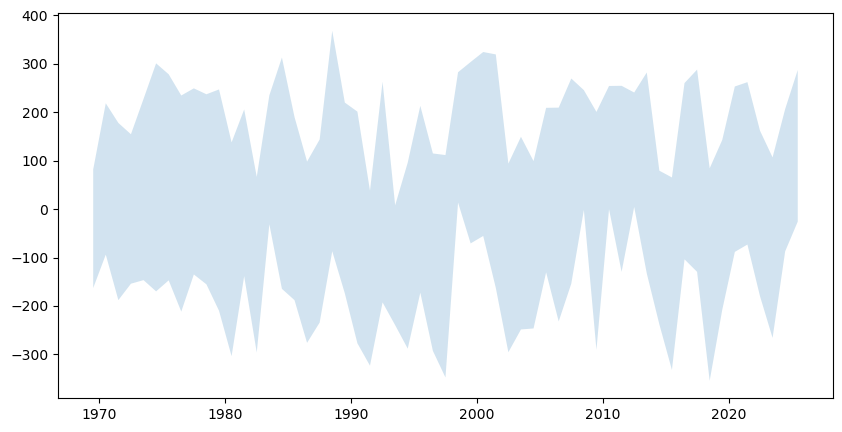

In [28]:
rsl_yearly_min = rsl_years.groupby('storm_time.year').min('storm_time').isel(record_id=0)
rsl_yearly_max = rsl_years.groupby('storm_time.year').max('storm_time').isel(record_id=0)
rsl_yearly_min = rsl_yearly_min['sea_level_anomaly_detrended']
rsl_yearly_max = rsl_yearly_max['sea_level_anomaly_detrended']
#make a fill from max to min for each month
fig, ax = plt.subplots(figsize=(10,5))
ax.fill_between(rsl_yearly_mean.storm_year+0.5, 
                 rsl_yearly_min, rsl_yearly_max, 
                 alpha=0.2, label='Range (Annual SLA Min-Max)')